# 核支持向量机
核支持向量机（通常简称为SVM）是可以推广到更复杂模型的扩展，这些模型无法被输入空间的超平面定义。向量机可以同时用于分类和回归。

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


# 线性模型与非线性验证
线性模型在低维空间中可能非常受限，因为线和平面的灵活性有限。有一种方法可以让线性模型更加灵活，就是添加更多的特征——举个例子，添加输入特征的交互项或多项式。

Text(0, 0.5, 'Feaature 1')

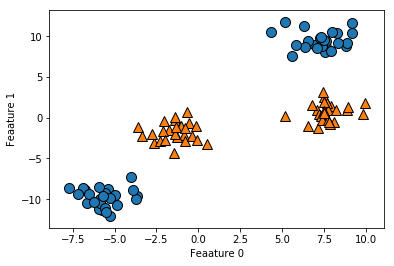

In [2]:
from sklearn.datasets import make_blobs
X,y=make_blobs(centers=4,random_state=8)

y=y%2

mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

用于分类的线性模型只能用一条直线来划分数据点，对这个数据集无法给出较好的结果：

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feaature 1')

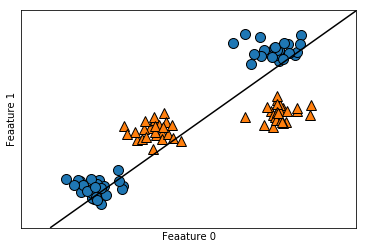

In [3]:
from sklearn.svm import LinearSVC

linear_svm=LinearSVC().fit(X,y)

mglearn.plots.plot_2d_separator(linear_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

现在我们对输入特征进行扩展，比如说添加第二个特征的平方（feature1 ** 2）作为一个新特征，现在我们将每个数据点表示为三维点（feature0,feature1,feature1 ** 2）,而不是二维点（feature0,feature1）。我们将这个心的表示画出三维散点图：

Text(0.5, 0, 'feature1**2')

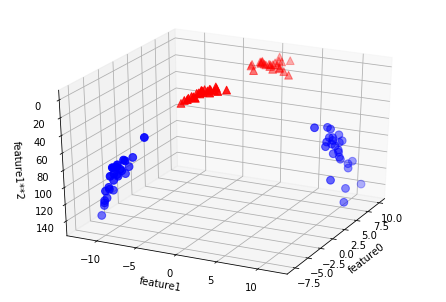

In [4]:
X_new=np.hstack([X,X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D,axes3d
figure=plt.figure()
# 3D可视化
ax=Axes3D(figure,elev=-152,azim=-26)
# 首先画出所有y==0的点，然后画出所有y==1的点
mask= y==0
ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")

在数据的新表示中，现在可以用线性模型（三维空间中的平面）将这两个类别分开。我们可以用线性模型拟合扩展后的数据来验证这一点：

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1**2')

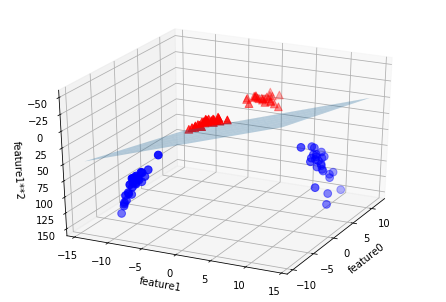

In [7]:
linear_svm_3d=LinearSVC().fit(X_new,y)
coef,intercept=linear_svm_3d.coef_.ravel(),linear_svm_3d.intercept_

# 显示线性决策边界
figure=plt.figure()
ax=Axes3D(figure,elev=-152,azim=-26)
xx=np.linspace(X_new[:,0].min()-2,X_new[:,0].max()+2,50)
yy=np.linspace(X_new[:,1].min()-2,X_new[:,1].max()+2,50)

XX,YY=np.meshgrid(xx,yy)
ZZ=(coef[0]*XX+coef[1]*YY+intercept)/-coef[2]
ax.plot_surface(XX,YY,ZZ,rstride=8,cstride=8,alpha=0.3)
ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")

如果将线性模型SVM看作原始特征的函数，那么它实际上已经不是线性的了。它不是一条直线，而是一个椭圆，你可以在下图中看出:

Text(0, 0.5, 'Feature 1')

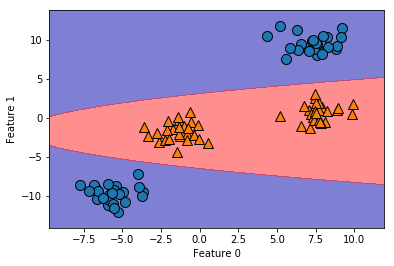

In [9]:
ZZ=YY**2
dec=linear_svm_3d.decision_function(np.c_[XX.ravel(),YY.ravel(),ZZ.ravel()])
plt.contourf(XX,YY,dec.reshape(XX.shape),levels=[dec.min(),0,dec.max()],cmap=mglearn.cm2,alpha=0.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# 核技巧
向数据表示中添加非线性特征，可以让线性模型变得更强大。但是，通常来说我们并不知道要添加哪些特征，而且添加许多特征（比如100维特征空间所有可能的交互项）的计算开销可能很大。幸运的是，有一种巧妙的数学技巧，让我们可以在更高维空间中学习分类器，而不用实际计算可能非常大的新的数据表示。这种技巧叫作核技巧（kernel trick）,它的原理是直接计算扩展特征表示表示中数据点之间的距离（更准确地说是内积），而不用对扩展进行计算。 
对于支持向量机，将数据映射到更高维空间中有两种常用的方法：一种是多项式核，在一定阶数内计算原始特征所有可能的多项式（比如feature1 ** 2 ** feature2 ** 5）;另一种是径向基函数（radial basis function,RBF）核，也叫高斯核。高斯核有点难以解释，因为它对应无限维的特征空间。一种对高斯核的解释是它考虑所有阶数的所有可能的多项式，但阶数越高，特征的重要性越小。  

# 理解SVM
在训练过程中，SVM学习每个训练数据点对于表示两个类别之间的决策边界的重要性。通常只有一部分训练数据点对于定义边界来说很重要：位于类别之间边界上的那些点。这些点叫作**支持向量（support vector）**,支持向量机正是由此得名。  
想要对新样本进行预测，需要测量它与每个支持向量机之间的距离。分类决策是基于它与支持向量之间的距离以及在训练过程中学到的支持向量重要性（保存在SVC的dual_coef_属性中）来做出的。  
数据点之间的距离有高斯核给出：
Krbf(x1,x2)=exp(-Y||x1-x2|| ** 2)  
这里x1和x2是数据点，||x1-x2||表示欧式距离，y(gamma)是控制高斯核宽度的参数。  
如下是支持向量机对于一个二维二分类数据集的训练结果。决策边界用黑色表示，支持向量是尺寸较大的点：